# Application with new data

This tutorial demonstrates spatial data alignment on new BaristaSeq mouse data and STARmap mouse data using Pysodb and Paste.

This tutorial refers to the following tutorial at https://github.com/raphael-group/paste_reproducibility/blob/main/notebooks/DLPFC_pairwise.ipynb. At the same time, the way of loadding data is modified by using Pysodb.

## Import packages and set configurations

In [1]:
# Imports various packages for data analysis and visualization. 
# pandas: used for data manipulation and analysis.
import pandas as pd
# numpy: used for numerical computing, including mathematical operations on arrays and matrices.
import numpy as np
# seaborn: used for statistical data visualization, providing high-level interfaces for creating informative and attractive visualizations.
import seaborn as sns
# matplotlib: a comprehensive library for creating static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
# time: provides time-related functions, such as measuring execution time and converting between time formats.
import time
# scanpy: a Python package for single-cell gene expression analysis, including preprocessing, clustering, and differential expression analysis.
import scanpy as sc
# networkx: a Python package for creating, manipulating, and studying complex networks.
import networkx as nx
style.use('seaborn-white')

/tmp/ipykernel_72494/185176416.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [2]:
# Import paste package
import paste as pst

## Streamline development of loading spatial data with Pysodb

In [3]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [4]:
# Initialization
sodb = pysodb.SODB()


In [5]:
# Load two kind data
adata_list_baristaseq = sodb.load_dataset('Sun2021Integrating')
adata_starmap = sodb.load_dataset('Dataset11_MS_raw')['Dataset11']


load experiment[Slice_1] in dataset[Sun2021Integrating]
load experiment[Slice_3] in dataset[Sun2021Integrating]
load experiment[Slice_2] in dataset[Sun2021Integrating]
load experiment[Dataset11] in dataset[Dataset11_MS_raw]


## Preparation 

In [6]:
# Create a adata_list_starmap dictionary and split adata_starmap into subsets based "slice_id" 
adata_list_starmap = {}
for si in adata_starmap.obs['slice_id'].cat.categories:
    a = adata_starmap[adata_starmap.obs['slice_id']==si]
    a.obs['layer'] = a.obs['gt'].astype('str')
    a.obs['layer'] = a.obs['layer'].astype('category')
    adata_list_starmap[a.obs['slice_id'][0]] = a

/tmp/ipykernel_72494/4197310715.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['layer'] = a.obs['gt'].astype('str')
/tmp/ipykernel_72494/4197310715.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['layer'] = a.obs['gt'].astype('str')
/tmp/ipykernel_72494/4197310715.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['layer'] = a.obs['gt'].astype('str')


In [7]:
# Combine adata_list_baristaseq and adata_list_starmap 
adata_list = adata_list_baristaseq
adata_list.update(adata_list_starmap)

In [8]:
# Define a list containing the keys of adata_list
sample_list = ["Slice_1", "Slice_2", "Slice_3",'BZ5','BZ9','BZ14']

In [9]:
# Define a function called rotate_translate to generate a random rotation and translation
import numpy as np
import random

def rotate_translate(matrix):
    # Create rotation matrix
    theta = random.uniform(0, 2 * np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    # Calculate translation bounds
    max_coords = np.max(matrix, axis=0)
    min_coords = np.min(matrix, axis=0)
    translation_bounds = 0.5 * (max_coords - min_coords)

    # Generate random translation vector within bounds
    translation_vector = np.array([random.uniform(-translation_bounds[0], translation_bounds[0]),
                                   random.uniform(-translation_bounds[1], translation_bounds[1])])

    # Apply rotation and translation
    new_matrix = np.dot(matrix, rotation_matrix) + translation_vector

    return new_matrix

In [10]:
# Remove either 'VISp' or 'outside_VISp' for each sub-dataset in adata_list
# Apply a transformation to 'spatial' of each sub-dataset via rotate_translate()
adatas = {}
for key in sample_list:
    a = adata_list[key]
    a = a[np.logical_not((a.obs['layer']=='VISp') | (a.obs['layer']=='outside_VISp'))]
    
    new_spatial = rotate_translate(a.obsm['spatial'])
    a.obsm['spatial'] = new_spatial
    adatas[key] = a

In [11]:
# Define two lists, sample_groups and layer_groups, that organize data into different groups based on sample slices and brain regions
# Map specific brain regions to colors using a dictionary
# The seaborn color palette is used to assign colors to each brain region
sample_groups = [["Slice_1", "Slice_2", "Slice_3"],['BZ5','BZ9','BZ14',]]
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
cmp = sns.color_palette()
layer_to_color_map = {
    'VISp_I':cmp[0],
    'VISp_II/III':cmp[1],
    'VISp_IV':cmp[2],
    'VISp_V':cmp[3],
    'VISp_VI':cmp[4],
    'VISp_wm':cmp[5],
    '1':cmp[6],
    '2':cmp[7],
    '3':cmp[8],
    '4':cmp[9],
}


In [12]:
# Redefine a function called visualize_slices to generate a visualization of tissue regions for different samples and different slices
def visualize_slices(layer_groups, adatas, sample_list, slice_map, layer_to_color_map, key):
    n_rows = len(layer_groups)
    n_cols = len(layer_groups[0])

    plot, axs = plt.subplots(n_rows, n_cols, figsize=(15, 11.5))

    for j in range(n_rows):
        axs[j, 0].text(-0.1, 0.5, 'Sample ' + slice_map[j], fontsize=12, rotation='vertical', transform=axs[j, 0].transAxes, verticalalignment='center')
        for i in range(n_cols):
            adata = adatas[sample_list[j * n_cols + i]]
            colors = list(adata.obs[key].astype('str').map(layer_to_color_map))
            colors = [(r, g, b) for r, g, b in colors]

            axs[j, i].scatter(layer_groups[j][i].obsm['spatial'][:, 0], layer_groups[j][i].obsm['spatial'][:, 1], linewidth=0, s=20, marker=".",
                              color=colors
                              )
            axs[j, i].set_title('Slice ' + slice_map[i], size=12)
            axs[j, i].invert_yaxis()
            axs[j, i].axis('off')
            axs[j, i].axis('equal')
            """
            if i<n_cols-1:
                s = '300$\mu$m' if i==1 else "10$\mu$m"
                delta = 0.05 if i==1 else 0
                axs[j,i].annotate('',xy=(1-delta, 0.5), xytext=(1.2+delta, 0.5),xycoords=axs[j,i].transAxes,textcoords=axs[j,i].transAxes,arrowprops=dict(arrowstyle='<->',lw=1))
                axs[j,0].text(1.1, 0.55, s,fontsize=9,transform = axs[j,i].transAxes,horizontalalignment='center')
            """
        legend_handles = [mpatches.Patch(color=layer_to_color_map[adata.obs[key].cat.categories[i]], label=adata.obs[key].cat.categories[i]) for i in range(len(adata.obs[key].cat.categories))]
        axs[j, n_cols-1].legend(handles=legend_handles, fontsize=10, title='Cortex layer', title_fontsize=12, bbox_to_anchor=(1, 1))

    return plot

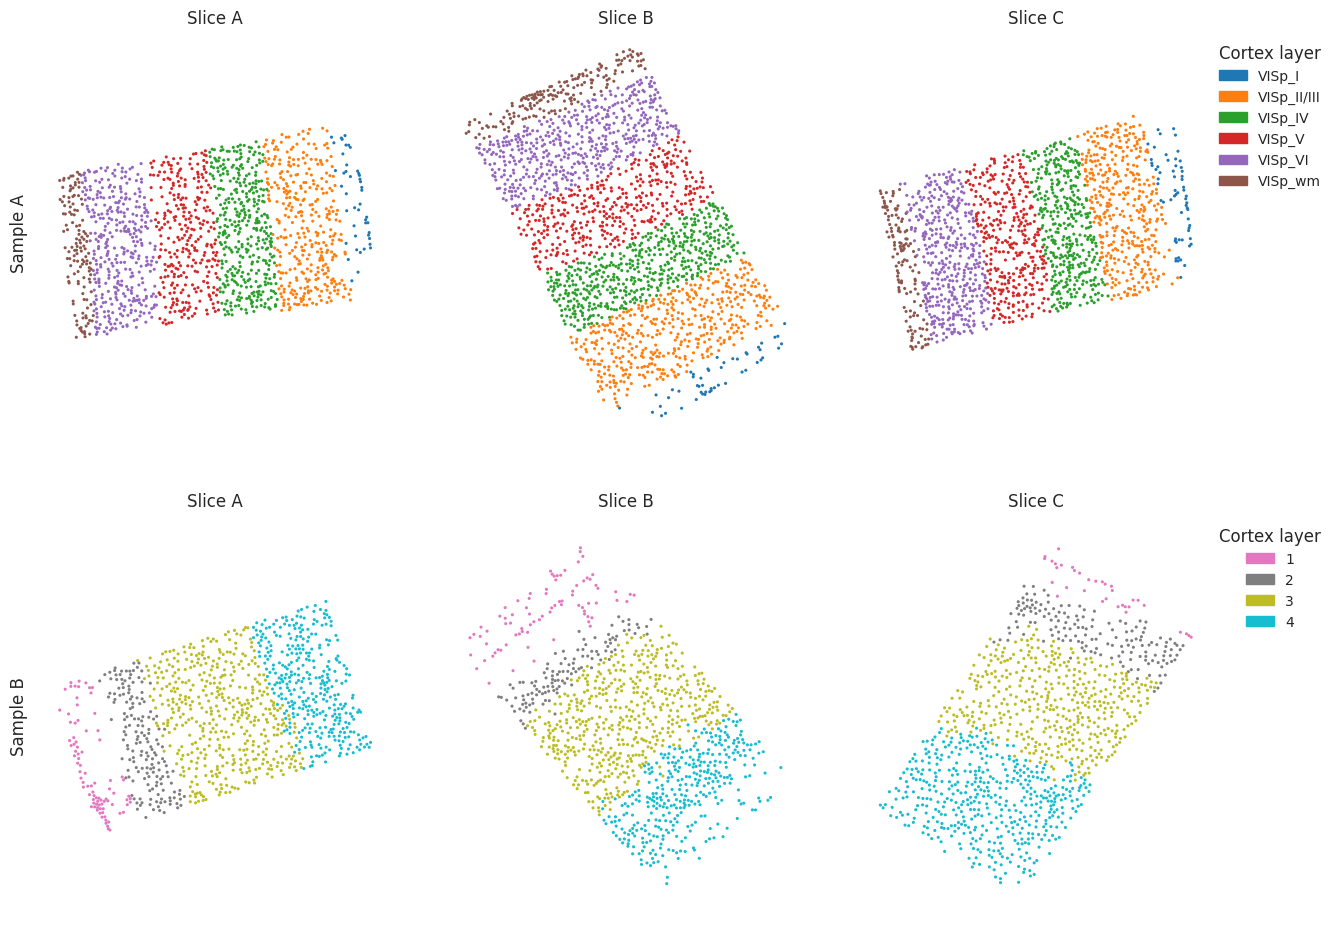

In [13]:
# Define a dictionary for slice map
slice_map = {0: 'A', 1: 'B', 2: 'C'}
# Visualize the different slices mapped by layer_groups
plot = visualize_slices(layer_groups, adatas, sample_list, slice_map, layer_to_color_map, key= 'layer')
plt.show()

## Running PASTE for alignment

In [14]:
# Redefine compute_pairwise_alignment function to compute the pairwise alignment between consecutive layers within each layer group, stores the resulting mappings in a list called pis
def compute_pairwise_alignment(groups, alpha=0.1):
    pis = [[None for i in range(len(groups[j])-1)] for j in range(len(groups))]
    
    for j in range(len(groups)):
        for i in range(len(groups[j])-1):
            pi0 = pst.match_spots_using_spatial_heuristic(groups[j][i].obsm['spatial'], groups[j][i+1].obsm['spatial'], use_ot=True)
            start = time.time()
            pis[j][i] = pst.pairwise_align(groups[j][i], groups[j][i+1], alpha=alpha, G_init=pi0, norm=True, verbose=False)
            tt = time.time() - start
            print(j, i, 'time', tt)

    return pis

In [15]:
pis = compute_pairwise_alignment(groups = layer_groups, alpha=0.1)

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
0 0 time 20.315631866455078
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
0 1 time 26.11185622215271
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
1 0 time 6.043396711349487
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
1 1 time 10.50022840499878


In [16]:
# Align spatial coordinates of sequential pairwise slices
paste_layer_groups = [pst.stack_slices_pairwise(layer_groups[j], pis[j]) for j in range(len(layer_groups)) ]

In [17]:
paste_layer_groups

[[AnnData object with n_obs × n_vars = 1525 × 79
      obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'leiden'
      uns: 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
      obsm: 'X_pca', 'X_umap', 'spatial'
      varm: 'PCs'
      obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances',
  AnnData object with n_obs × n_vars = 2042 × 79
      obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'leiden'
      uns: 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
      obsm: 'X_pca', 'X_umap', 'spatial'
      varm: 'PCs'
      obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances',
  AnnData object with n_obs × n_vars = 1690 × 79
      obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom'

In [18]:
#  Define a function to plots spatial coordinates of cells in different groups
def plot_slices_overlap(groups, adatas, sample_list, layer_to_color_map,save=None):
    marker_list = ['*','^','+']
    for j in range(len(groups)): 
        plt.figure(figsize=(10,10))
        for i in range(len(groups[j])):
            adata = adatas[sample_list[j*3+i]]
            colors = list(adata.obs['layer'].astype('str').map(layer_to_color_map))
            plt.scatter(groups[j][i].obsm['spatial'][:,0],groups[j][i].obsm['spatial'][:,1],linewidth=1,s=80, marker=marker_list[i],color=colors,alpha=0.8)
        plt.legend(handles=[mpatches.Patch(color=layer_to_color_map[adata.obs['layer'].cat.categories[i]], label=adata.obs['layer'].cat.categories[i]) for i in range(len(adata.obs['layer'].cat.categories))],fontsize=10,title='Cortex layer',title_fontsize=15,bbox_to_anchor=(1, 1))
        plt.gca().invert_yaxis()
        plt.axis('off') 
        plt.axis('equal')
        if save is None:
            plt.show()
        else:
            plt.savefig(f'{save}_{j}.pdf',bbox_inches='tight',transparent=True)
        

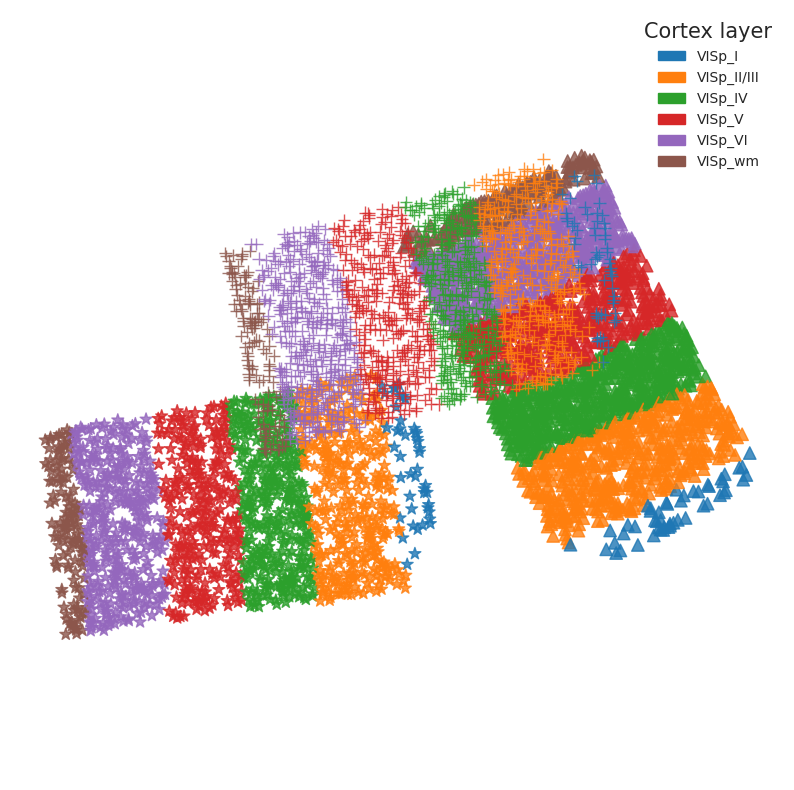

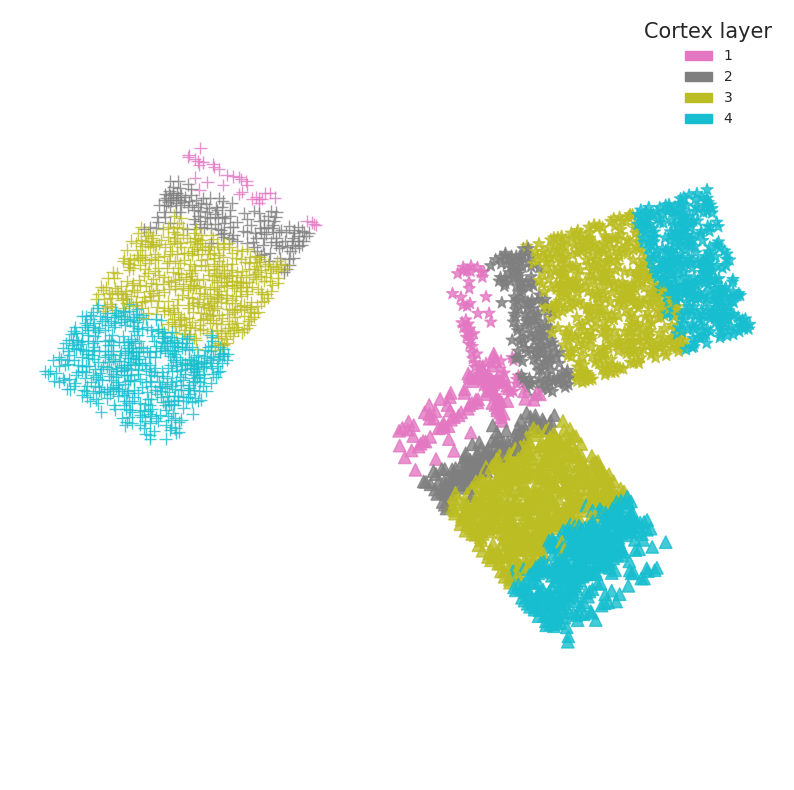

In [19]:
# Plot Stacking of slices without alignment
plot_slices_overlap(layer_groups, adatas, sample_list, layer_to_color_map)


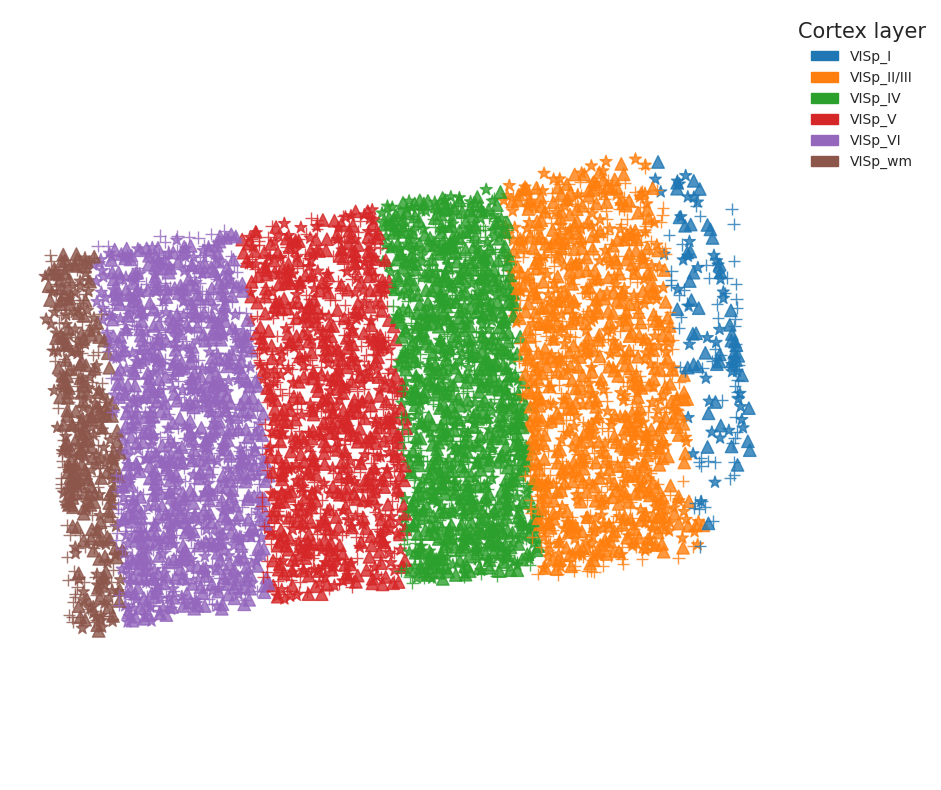

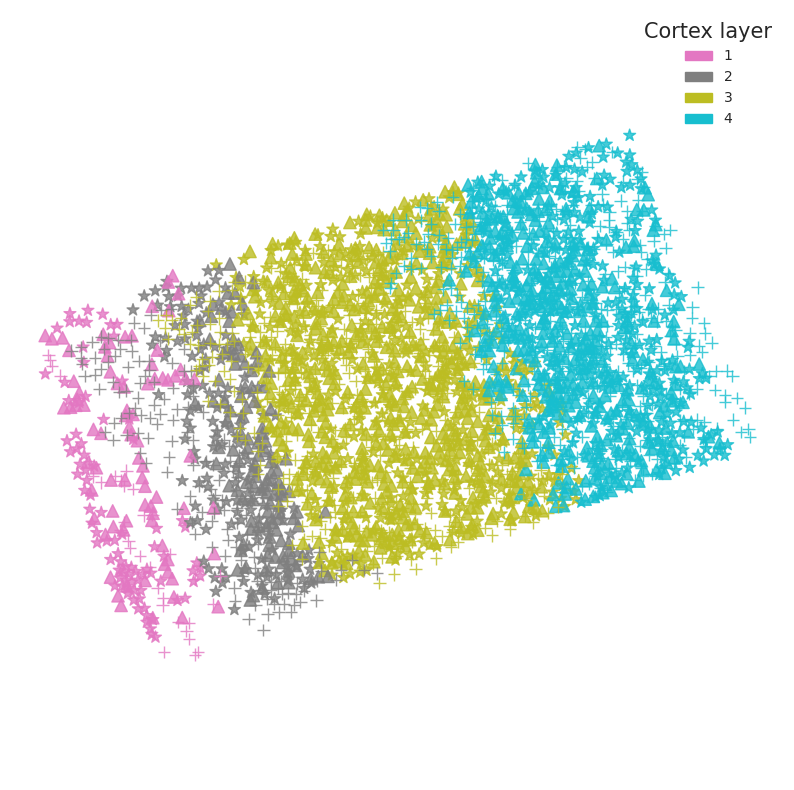

In [20]:
# Plot Stacking of slices with PASTE alignment
plot_slices_overlap(paste_layer_groups, adatas, sample_list, layer_to_color_map)


In [21]:
# Redefine a generate_3d_spatial_data function to add a third spatial dimension to the spatial data by stacking an array of j*100 values for each group of the list 'groups'

def generate_3d_spatial_data(groups, dataset_name='new', save=False):
    spatial_3d_data = []
    
    for i in range(len(groups)):
        rsta_list = []
        
        for j in range(len(groups[i])):
            a = groups[i][j]
            spatial = a.obsm['spatial']
            spatial_z = np.ones(shape=(spatial.shape[0],1))*j*100
            spatial_3d = np.hstack([spatial,spatial_z])
            a.obsm['spatial_3d'] = spatial_3d
            rsta_list.append(a)
            
        a_concat = rsta_list[0].concatenate(rsta_list[1:])
        spatial_3d_data.append(a_concat)
        
        if save:
            a_concat.write_h5ad(f'{dataset_name}_sample{i}_3d.h5ad')
            
    return spatial_3d_data

In [22]:
layer_groups_spatial_3d_data = generate_3d_spatial_data(layer_groups, dataset_name='new', save=True)

/home/linsenlin/anaconda3/envs/alignment/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/linsenlin/anaconda3/envs/alignment/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/linsenlin/anaconda3/envs/alignment/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from 

In [23]:
paste_layer_groups_spatial_3d_data = generate_3d_spatial_data(paste_layer_groups, dataset_name='new', save=True)

/home/linsenlin/anaconda3/envs/alignment/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/linsenlin/anaconda3/envs/alignment/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/linsenlin/anaconda3/envs/alignment/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from 